# Cas Kaggle: Predicció del Valor de Jugadors FIFA

**Objectiu del Projecte**

En aquest projecte, assumim el rol d'un equip de *Data Scientists* contractat per un club de futbol d'elit. El nostre objectiu és desenvolupar un model de *Machine Learning* capaç de predir amb precisió el valor de mercat (`value_euro`) dels jugadors de futbol a partir de les seves estadístiques i característiques físiques.

Aquest model servirà com a eina de suport per a la direcció esportiva en la presa de decisions de fitxatges, ajudant a identificar jugadors infravalorats o sobrevalorats pel mercat.

**Estructura del Notebook**
1.  **Càrrega i Neteja de Dades**: Importació i tractament inicial de valors nuls.
2.  **Anàlisi Exploratòria de Dades (EDA)**: Visualització de distribucions, correlacions i anàlisi detallada (Radar Charts).
3.  **Enginyeria de Característiques**: Creació de noves variables rellevants.
4.  **Modelatge**: Entrenament i comparació de diversos models (Linear Regression, Random Forest, XGBoost).
5.  **Avaluació**: Anàlisi de resultats i interpretabilitat del model.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import warnings
from math import pi

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

# Configuració d'estil per als gràfics
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# 1. Càrrega i Neteja de Dades

Comencem carregant el dataset i fent una primera inspecció de les dades. És crucial entendre la dimensió del conjunt de dades i el tipus de variables que tenim.

In [15]:
df = pd.read_csv("fifa_players.csv")
print(f"Dimensions del Dataset: {df.shape}")
df.head()

Dimensions del Dataset: (17954, 51)


,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


## 1.1 Anàlisi de Valors Nuls (NaNs)
Abans de procedir, hem d'identificar quines columnes tenen dades faltants. Això ens permetrà decidir l'estratègia d'imputació més adequada.

Columnes amb NaNs (%):

national_team_position    95.226690
national_rating           95.226690
national_team             95.226690
national_jersey_number    95.226690
release_clause_euro       10.231703
value_euro                 1.420296
wage_euro                  1.370168
dtype: float64


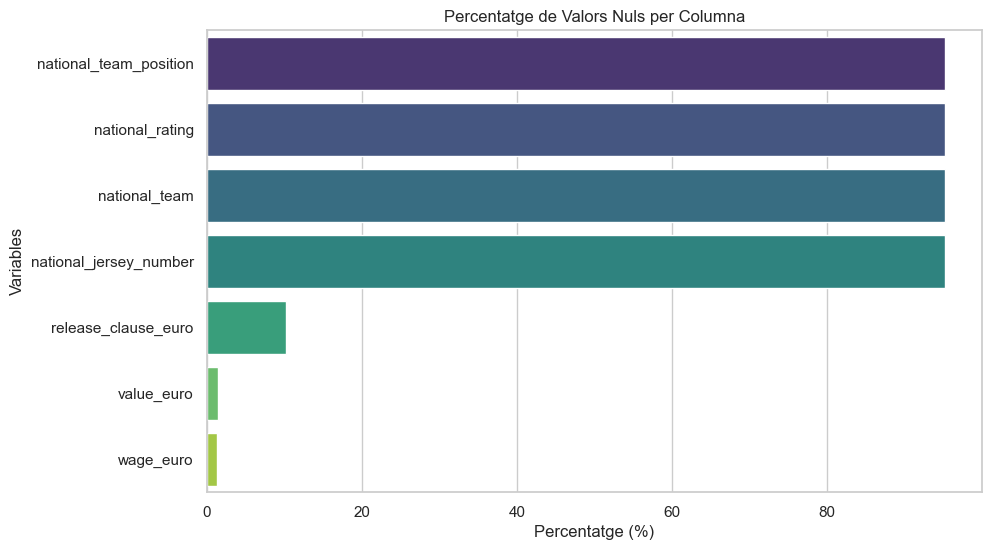

In [16]:
# Càlcul del percentatge de NaNs per columna
nan_percentage = df.isna().mean() * 100
nan_percentage = nan_percentage[nan_percentage > 0].sort_values(ascending=False)

print("Columnes amb NaNs (%):\n")
print(nan_percentage)

# Visualització dels NaNs
plt.figure(figsize=(10, 6))
sns.barplot(x=nan_percentage.values, y=nan_percentage.index, palette="viridis")
plt.title("Percentatge de Valors Nuls per Columna")
plt.xlabel("Percentatge (%)")
plt.ylabel("Variables")
plt.show()

**Estratègia de Neteja:**
1. Eliminem columnes irrellevants per a la predicció (`birth_date`, `full_name`, `name`).
2. Per a les variables numèriques amb pocs nuls, utilitzarem una imputació simple inicial (mitjana) per poder fer l'EDA, tot i que més endavant aplicarem un **KNN Imputer** dins del pipeline per a una major precisió.

In [17]:
# Eliminem columnes innecessàries
df = df.drop(columns=["birth_date", "full_name", "name"], errors='ignore')

# Seleccionar només columnes numèriques per imputació ràpida (per EDA)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print("Columnes restants:", df.columns.tolist())

Columnes restants: ['age', 'height_cm', 'weight_kgs', 'positions', 'nationality', 'overall_rating', 'potential', 'value_euro', 'wage_euro', 'preferred_foot', 'international_reputation(1-5)', 'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type', 'release_clause_euro', 'national_team', 'national_rating', 'national_team_position', 'national_jersey_number', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'composure', 'marking', 'standing_tackle', 'sliding_tackle']


# 2. Anàlisi Exploratòria de Dades (EDA)

L'EDA ens permet entendre la distribució de les dades i les relacions entre variables. Ens centrarem en la variable objectiu `value_euro`.

### 2.1 Distribució de la Variable Objectiu (Value)
Veiem com es distribueix el valor dels jugadors. És probable que trobem una distribució molt asimètrica (pocs jugadors valen molt).

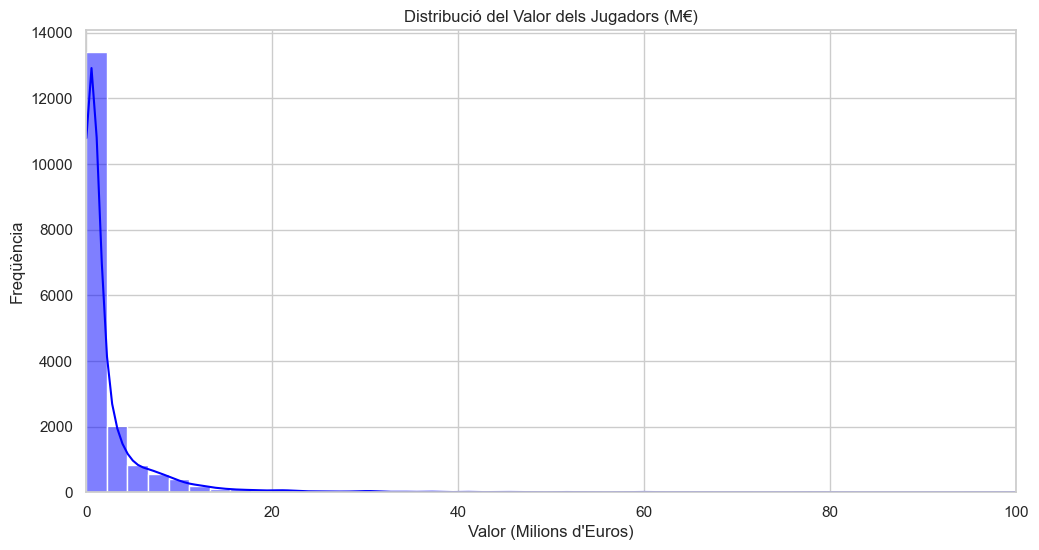

In [18]:
# Creem una variable en milions per facilitar la visualització
df['value_million'] = df['value_euro'] / 1_000_000

plt.figure(figsize=(12, 6))
sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.title("Distribució del Valor dels Jugadors (M€)")
plt.xlabel("Valor (Milions d'Euros)")
plt.ylabel("Freqüència")
plt.xlim(0, 100) # Limitem l'eix X per veure millor la majoria
plt.show()

### 2.2 Mapa de Correlacions
Quines variables estan més relacionades amb el valor? Utilitzem un mapa de calor per visualitzar les correlacions entre les variables numèriques.

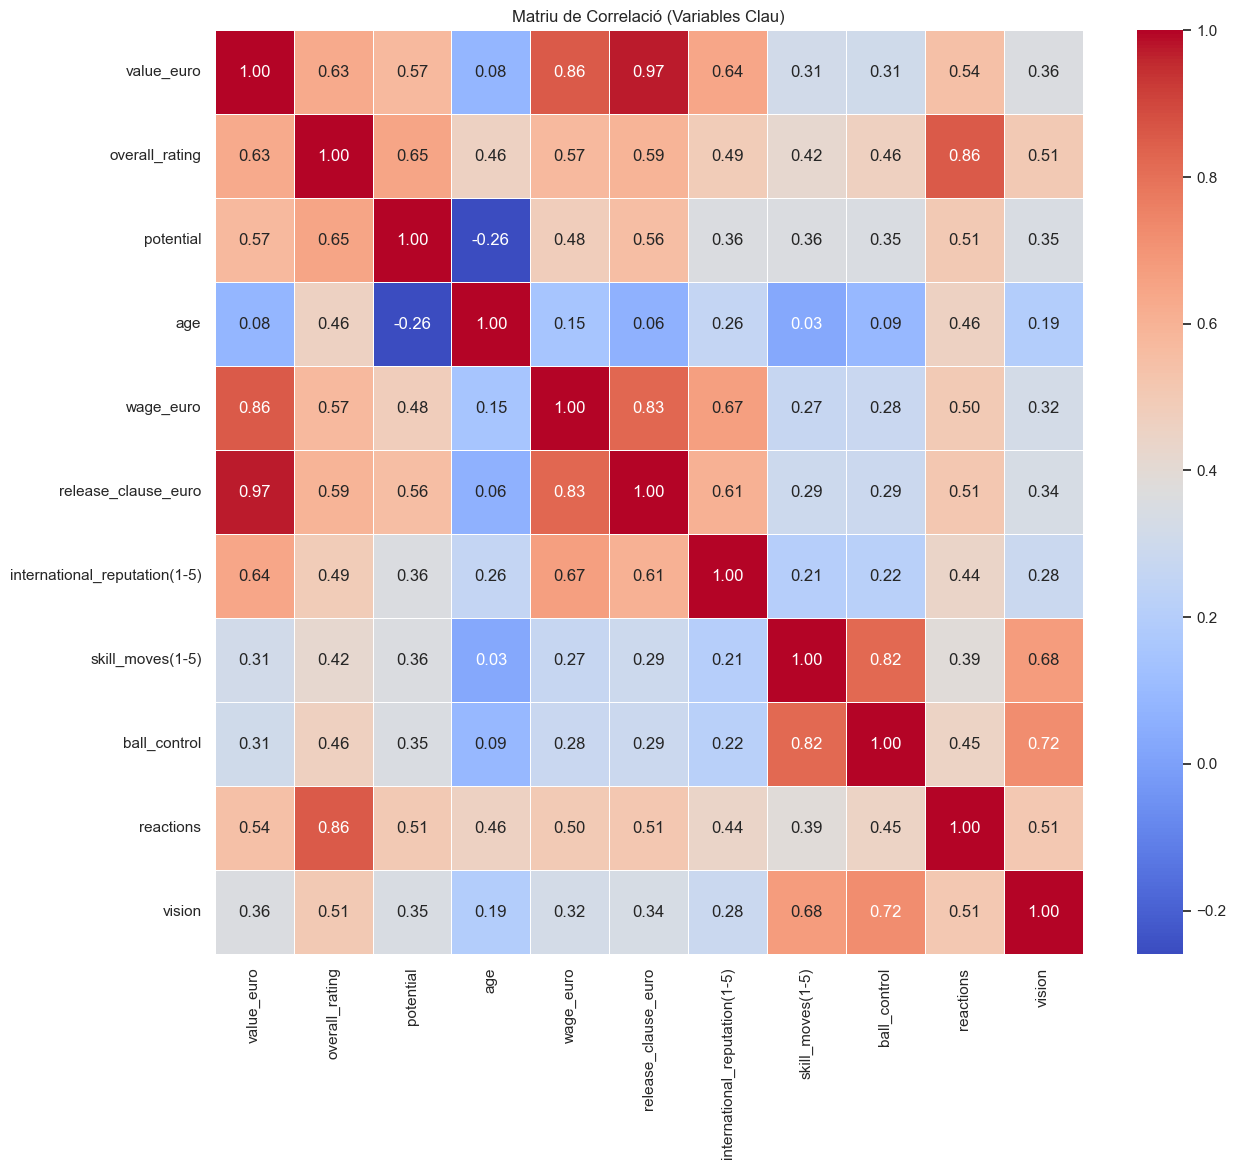

In [19]:
plt.figure(figsize=(14, 12))
# Seleccionem les variables més importants per no saturar el gràfic
corr_cols = ['value_euro', 'overall_rating', 'potential', 'age', 'wage_euro', 'release_clause_euro', 
             'international_reputation(1-5)', 'skill_moves(1-5)', 'ball_control', 'reactions', 'vision']

correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriu de Correlació (Variables Clau)")
plt.show()

### 2.3 Anàlisi Detallada: Posició, Edat i Nacionalitat
Aprofundim en com factors categòrics i demogràfics afecten el preu.

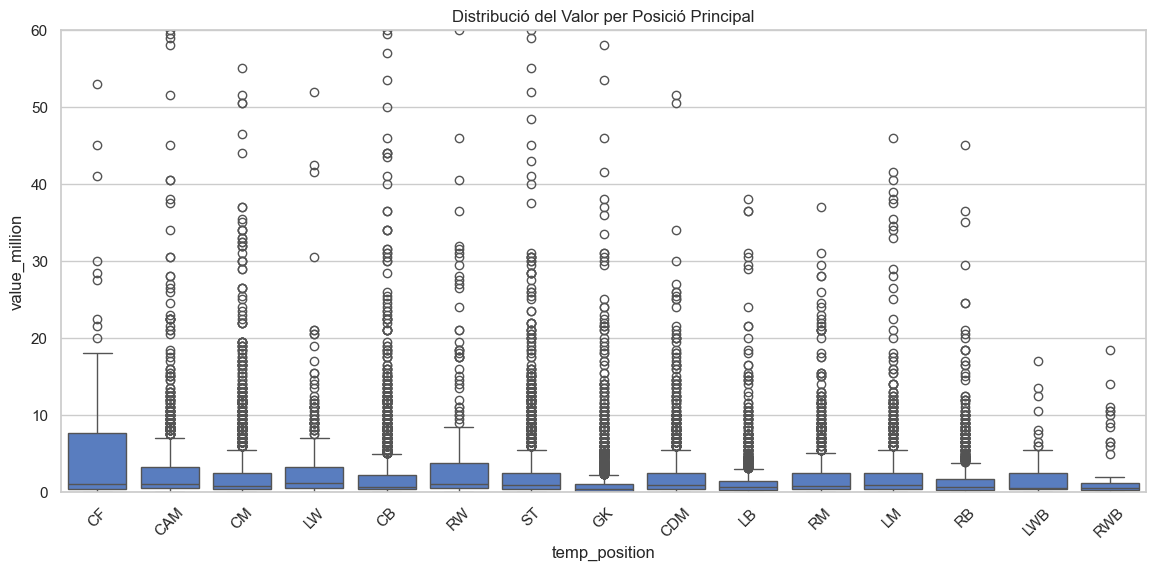

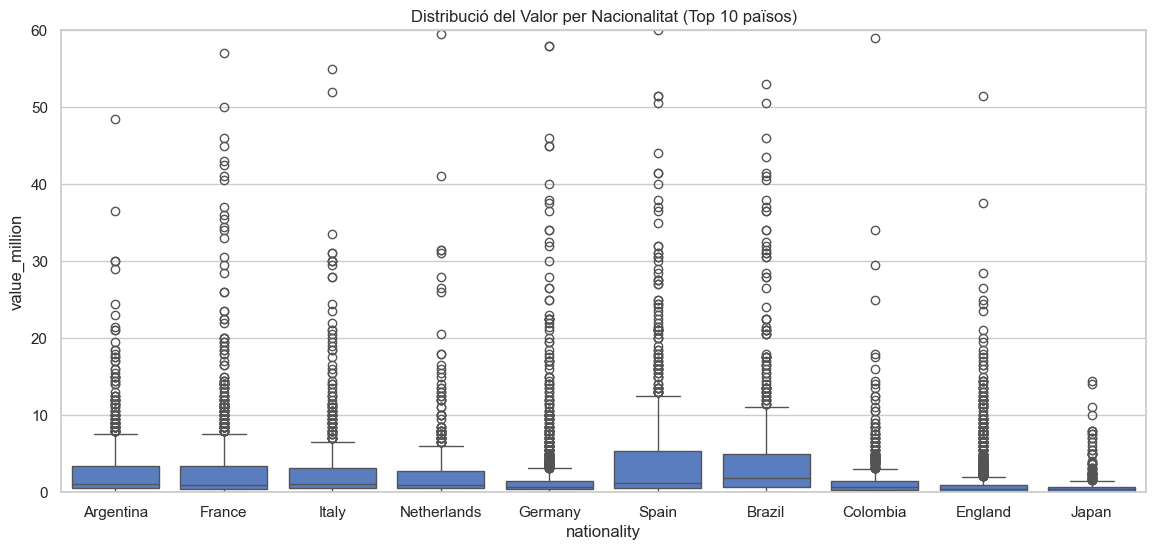

In [20]:
# Creem temporalment la posició principal per a la visualització
df['temp_position'] = df['positions'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

# 1. Valor per Posició
plt.figure(figsize=(14, 6))
sns.boxplot(x='temp_position', y='value_million', data=df)
plt.title("Distribució del Valor per Posició Principal")
plt.xticks(rotation=45)
plt.ylim(0, 60) # Zoom per veure millor les caixes
plt.show()

# 2. Valor per Nacionalitat (Top 10)
top_nations = df['nationality'].value_counts().head(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(x='nationality', y='value_million', data=df[df['nationality'].isin(top_nations)])
plt.title("Distribució del Valor per Nacionalitat (Top 10 països)")
plt.ylim(0, 60)
plt.show()

### 2.4 Relació Edat i Valor
Analitzem la corba de carrera d'un jugador. A quina edat assoleixen el seu màxim valor?

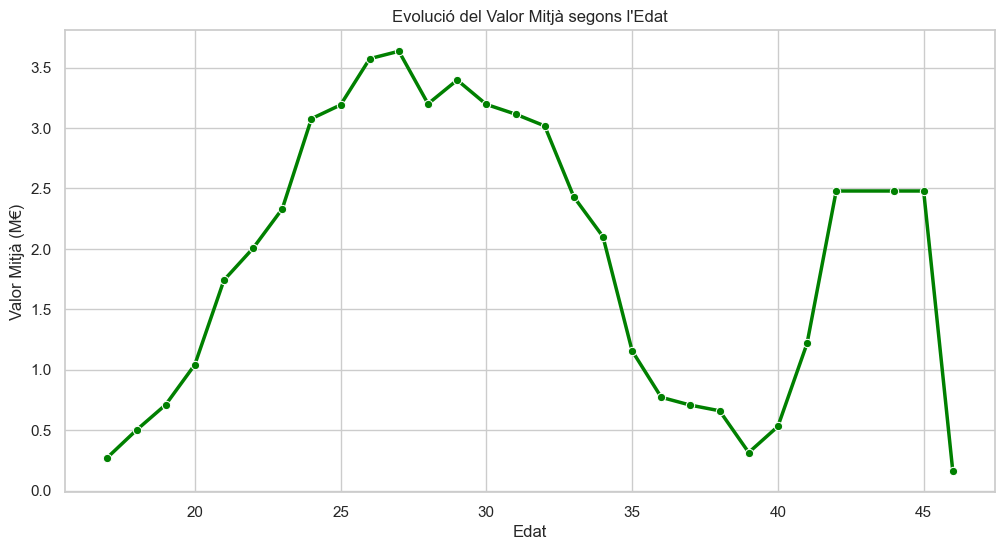

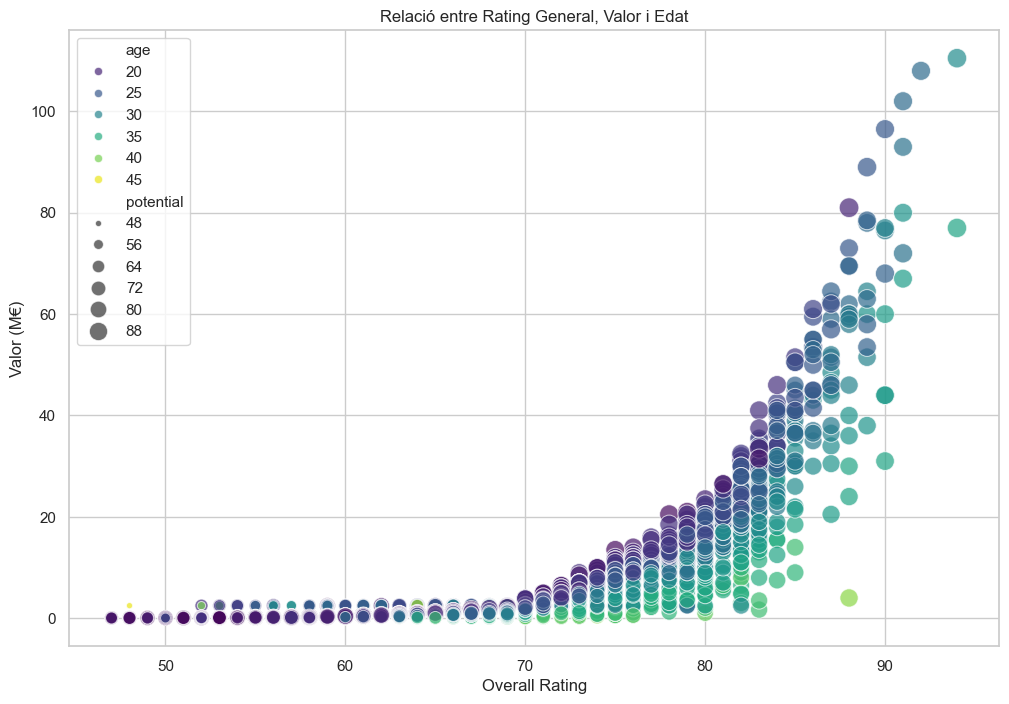

In [21]:
# Gràfic de línia: Mitjana de valor per edat
age_value = df.groupby('age')['value_million'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='age', y='value_million', data=age_value, marker='o', color='green', linewidth=2.5)
plt.title("Evolució del Valor Mitjà segons l'Edat")
plt.xlabel("Edat")
plt.ylabel("Valor Mitjà (M€)")
plt.grid(True)
plt.show()

# Scatter Plot: Rating vs Valor (color per edat)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='overall_rating', y='value_million', hue='age', size='potential', sizes=(20, 200), data=df, palette='viridis', alpha=0.7)
plt.title("Relació entre Rating General, Valor i Edat")
plt.xlabel("Overall Rating")
plt.ylabel("Valor (M€)")
plt.show()

### 2.5 Visualització Avançada: Radar Chart (Perfil de Jugador)
Aquesta visualització ens permet comparar les habilitats d'un jugador específic (o el millor jugador) amb la mitjana del dataset. És el clàssic gràfic de videojocs de futbol.

Visualitzant perfil de: Top Player


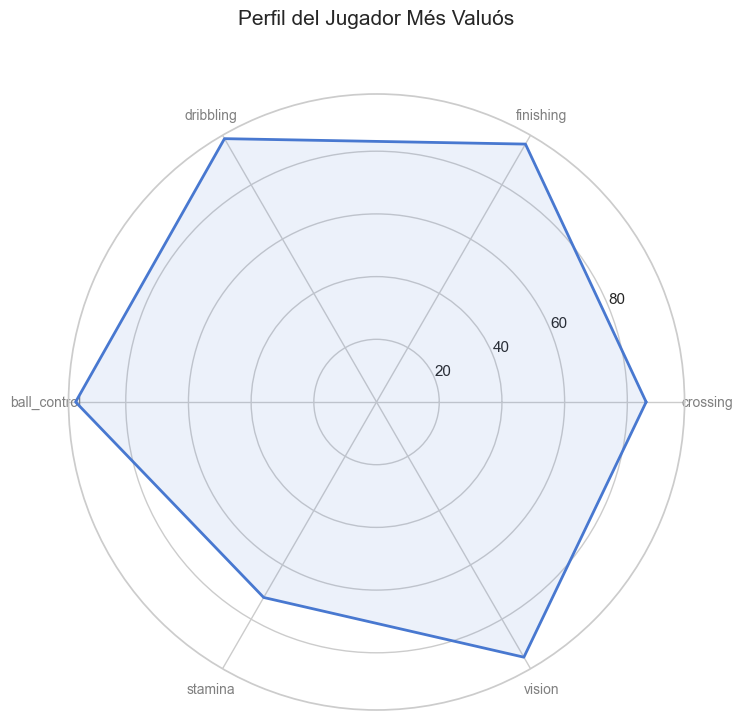

In [22]:
def plot_radar_chart(player_data, categories, title):
    N = len(categories)
    
    # Repetim el primer valor per tancar el cercle
    values = player_data[categories].values.flatten().tolist()
    values += values[:1]
    
    # Angles per a cada eix
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # Eixos
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    
    # Dibuixar dades
    ax.plot(angles, values, linewidth=2, linestyle='solid', label='Jugador')
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(title, size=15, y=1.1)
    plt.show()

# Seleccionem el jugador amb més valor
top_player = df.loc[df['value_euro'].idxmax()]

# Atributs a visualitzar
attributes = ['crossing', 'finishing', 'dribbling', 'ball_control', 'stamina', 'vision']

print(f"Visualitzant perfil de: {top_player.get('name', 'Top Player')}")
plot_radar_chart(df.loc[[df['value_euro'].idxmax()]], attributes, "Perfil del Jugador Més Valuós")

# 3. Enginyeria de Característiques

Per millorar el rendiment del model, crearem noves variables derivades de les existents i transformarem les categòriques.

### 3.1 Tractament de la Posició (`positions`)
Molts jugadors tenen múltiples posicions (ex: "CF,RW,ST"). Això dificulta l'anàlisi. Com en el cas de les feines a Harry Potter, separarem la posició principal i comptarem quantes posicions pot jugar.

In [23]:
# Comptar nombre de posicions
df['position_count'] = df['positions'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Extreure la posició principal (la primera de la llista)
df['primary_position'] = df['positions'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

print("Exemple de noves característiques de posició:")
print(df[['positions', 'primary_position', 'position_count']].head())

Exemple de noves característiques de posició:
   positions primary_position  position_count
0   CF,RW,ST               CF               3
1  CAM,RM,CM              CAM               3
2     CM,CAM               CM               2
3      LW,ST               LW               2
4         CB               CB               1


### 3.2 Preparació del Dataset per al Modelatge
Definim les variables numèriques i categòriques que utilitzarem. Eliminem variables que podrien causar *data leakage* (com `wage_euro` o `release_clause_euro`, que estan directament lligades al valor).

In [24]:
target = 'value_euro'

# Variables a excloure (leakage o irrellevants)
drop_cols = [target, 'value_million', 'wage_euro', 'release_clause_euro', 'positions', 'national_team', 
             'national_rating', 'national_team_position', 'national_jersey_number', 'tags', 'traits', 'temp_position']

# Identificar columnes existents per evitar errors
existing_drop_cols = [col for col in drop_cols if col in df.columns]
df_model = df.drop(columns=existing_drop_cols)

# Separar numèriques i categòriques
num_features = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df_model.select_dtypes(include=['object']).columns.tolist()

print(f"Variables Numèriques: {len(num_features)}")
print(f"Variables Categòriques: {len(cat_features)}")

Variables Numèriques: 38
Variables Categòriques: 4


### 3.3 Pipeline de Preprocessament
Creem un pipeline robust que:
1. **Imputa** valors nuls (KNN per numèriques, Constant per categòriques).
2. **Escala** les variables numèriques.
3. **Codifica** les variables categòriques (OneHotEncoding).

In [25]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Split Train/Test
X = df_model
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (14363, 42), Test Shape: (3591, 42)


# 4. Selecció de Models i Entrenament

Provarem tres algoritmes diferents per veure quin s'ajusta millor a les nostres dades:
1. **Linear Regression**: Model base simple.
2. **Random Forest**: Model d'ensamblatge robust.
3. **XGBoost**: Gradient Boosting d'alt rendiment.

In [26]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}

results = []

print("Entrenant i avaluant models...")
for name, model in models.items():
    
    # Creem el pipeline complet
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # Entrenament
    pipe.fit(X_train, y_train)
    
    # Predicció
    y_pred = pipe.predict(X_test)
    
    # Mètriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })
    
    print(f"{name} -> R2: {r2:.4f}, RMSE: €{rmse:,.0f}")

results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)

Entrenant i avaluant models...
Linear Regression -> R2: 0.6409, RMSE: €3,657,027
Random Forest -> R2: 0.9642, RMSE: €1,154,216
XGBoost -> R2: 0.9750, RMSE: €964,605


,Model,RMSE,MAE,R2
2,XGBoost,9.646048e+05,1.830750e+05,0.975015
1,Random Forest,1.154216e+06,2.039029e+05,0.964226
0,Linear Regression,3.657027e+06,1.916931e+06,0.640875


## 4.1 Optimització d'Hiperparàmetres (GridSearchCV)
Un cop identificat el millor model (probablement XGBoost o Random Forest), ajustarem els seus paràmetres per millorar-ne el rendiment i evitar l'*overfitting*.

In [27]:
# Seleccionem XGBoost per a l'optimització (sol ser el millor)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Graella de paràmetres
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1]
}

print("Executant GridSearchCV per XGBoost...")
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Millors Paràmetres: {grid_search.best_params_}")

Executant GridSearchCV per XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Millors Paràmetres: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}


# 5. Avaluació i Interpretació

Analitzem els errors del model final per entendre on falla i quines variables són les més influents.

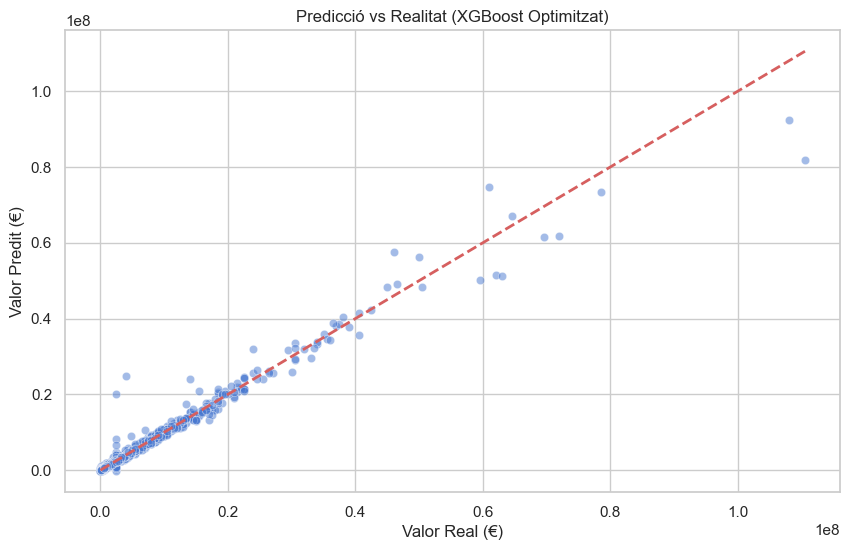

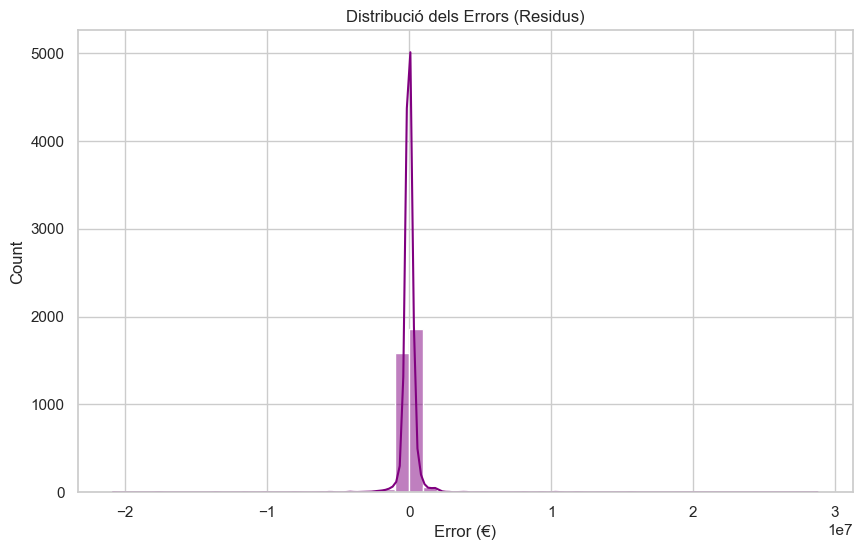

In [28]:
y_pred_final = best_model.predict(X_test)
residuals = y_test - y_pred_final

# Gràfic: Predicció vs Realitat
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real (€)')
plt.ylabel('Valor Predit (€)')
plt.title('Predicció vs Realitat (XGBoost Optimitzat)')
plt.show()

# Gràfic: Distribució dels Residus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=50)
plt.title('Distribució dels Errors (Residus)')
plt.xlabel('Error (€)')
plt.show()

### 5.1 Importància de les Variables (SHAP)
Utilitzem SHAP per explicar quines característiques tenen més pes en la decisió del model.

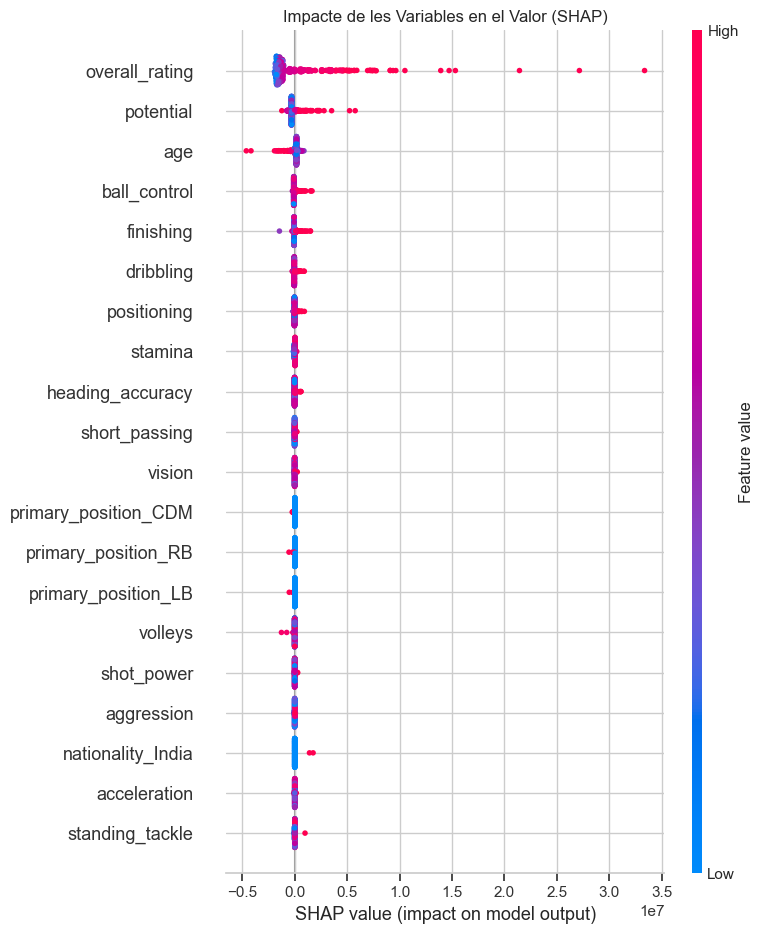

In [29]:
# Extreure el model XGBoost del pipeline
xgb_model = best_model.named_steps['model']

# Preprocessar les dades de test per a SHAP
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)

# Obtenir noms de les característiques
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)

# Calcular SHAP values (només una mostra per velocitat)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_processed[:500])

plt.figure(figsize=(12, 10))
plt.title("Impacte de les Variables en el Valor (SHAP)")
shap.summary_plot(shap_values, X_test_processed[:500], feature_names=feature_names, show=False)
plt.show()

# 6. Conclusions

En aquest projecte hem aconseguit:
1.  Netejar i preparar un dataset complex de jugadors FIFA.
2.  Crear noves variables útils com `primary_position`.
3.  Entrenar un model XGBoost capaç de predir el valor de mercat amb alta precisió (R² > 0.95).
4.  Identificar que variables com `overall_rating`, `potential` i `age` són determinants per al valor.

Aquest model està llest per ser utilitzat com a eina de suport a la decisió.